In [2]:
import numpy as np
concatenated_data = np.load("data_Phoebe_210626.npy")
concatenated_data = concatenated_data
print("Shape of the training data:", concatenated_data.shape)

import pickle
path = 'metadata_Phoebe_210626_withGT.pkl'
with open(path, 'rb') as f:
    metadata=pickle.load(f)
    print(metadata.keys())
    labels = metadata['labels']
    time_indices = metadata['time_indices']
    probs = metadata['prob']
    gt = metadata['GT']
    # sort the indices

concatenated_states = labels
print("Shape of the concatenated states:", concatenated_states.shape)

unique_states = np.unique(concatenated_states)
print(unique_states)

indices_per_state = {}
for state in unique_states:
    samples = np.where(concatenated_states == state)[0]
    indices_per_state[state] = samples

for state in indices_per_state:
    print(f"State {state} has {len(indices_per_state[state])} samples.")



Shape of the training data: (11402, 2000)
Index(['labels', 'time_indices', 'prob', 'GT'], dtype='object')
Shape of the concatenated states: (11392,)
['asynch_MA' 'awake' 'slow_MA' 'slow_updown' 'unknown']
State asynch_MA has 1899 samples.
State awake has 312 samples.
State slow_MA has 2022 samples.
State slow_updown has 5837 samples.
State unknown has 1322 samples.


In [3]:
# i want to know what state is the sample number 745
print(concatenated_states[745]) # i know this unknown is artifact really (technically)
# show me the probability of the sample number 745
print(probs[745])

# i know the sample number 344 is asynch_MA (technically)
print(concatenated_states[344])
print(probs[344]) #likely ?

unknown
0.10700288
unknown
0.8235216


In [4]:
from imblearn.over_sampling import SMOTE
THRESHOLD = 1000
def generate_synthetic_samples(data):
    smote = SMOTE()
    n_samples, n_features = data.shape
    # Since SMOTE expects labels, we can use dummy labels
    X_resampled, _ = smote.fit_resample(data, np.ones(n_samples))
    return X_resampled

waveforms_state = {}
for state in unique_states:
    indices = indices_per_state[state]
    waveforms_state[state] = concatenated_data[indices,:]

# reshape the waveforms to 2D (num_samples, channels*features)
waveforms_state_2d = {}
for state, waveforms in waveforms_state.items():
    num_samples = waveforms.shape[1]
    waveforms_2d = waveforms.reshape((-1, num_samples))  # flatten the channel and feature dimensions
    waveforms_state_2d[state] = waveforms_2d
    print(f"State {state} has {waveforms_2d.shape} shape.")

import gc
del concatenated_data
del concatenated_states
gc.collect()

State asynch_MA has (1899, 2000) shape.
State awake has (312, 2000) shape.
State slow_MA has (2022, 2000) shape.
State slow_updown has (5837, 2000) shape.
State unknown has (1322, 2000) shape.


0

In [5]:
from sklearn.model_selection import train_test_split

waveforms_train = {}
waveforms_test = {}

# Specify the fraction of data to be used for testing
test_size = 0.2

for state, waveforms_state in waveforms_state_2d.items():
    print(state)
    if state != 'unknown':  # Exclude state 4
        waveforms_state.transpose()
        test_size = 0.2
        waveforms_train_state, waveforms_test_state = train_test_split(waveforms_state, test_size=test_size,shuffle=True)
        # No need to transpose back to the original shape since our autoencoder will work on the 2D shape
        waveforms_train[state] = waveforms_train_state
        waveforms_test[state] = waveforms_test_state
    if state == 'awake':
        test_size = 0.1
        waveforms_train_state, waveforms_test_state = train_test_split(waveforms_state, test_size=test_size, shuffle=True)
        # No need to transpose back to the original shape since our autoencoder will work on the 2D shape
        waveforms_train[state] = waveforms_train_state
        waveforms_test[state] = waveforms_test_state
    if state == 'asynch_MA':
        test_size = 0.1
        waveforms_train_state, waveforms_test_state = train_test_split(waveforms_state, test_size=test_size,shuffle=True)
        # No need to transpose back to the original shape since our autoencoder will work on the 2D shape
        waveforms_train[state] = waveforms_train_state
        waveforms_test[state] = waveforms_test_state


print("Training and testing sets are:")
for state in waveforms_state_2d.keys():
    if state != 'unknown':  # Exclude state 4
        print(f"State {state}: {waveforms_train[state].shape} {waveforms_test[state].shape}")
    else:
        print(f"State {state}: {waveforms_state_2d[state].shape}")


asynch_MA
awake
slow_MA
slow_updown
unknown
Training and testing sets are:
State asynch_MA: (1709, 2000) (190, 2000)
State awake: (280, 2000) (32, 2000)
State slow_MA: (1617, 2000) (405, 2000)
State slow_updown: (4669, 2000) (1168, 2000)
State unknown: (1322, 2000)


In [6]:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def train_autoencoder(data, encoding_dim=55, epochs=250, batch_size=64):
    """
    Train an autoencoder for one-dimensional data.
    Arguments:
    data -- Training data, a 2D array-like where each row is a sample.
    encoding_dim -- Number of neurons in the bottleneck layer (default 32).
    epochs -- Number of epochs to train for (default 50).
    batch_size -- Number of samples per batch (default 256).
    Returns:
    autoencoder -- A trained model.
    """
    # Define the autoencoder structure
    autoencoder = Sequential()
    autoencoder.add(Dense(encoding_dim, activation='relu', input_shape=(data.shape[1],)))
    autoencoder.add(Dense(data.shape[1], activation='linear'))

    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # Train the autoencoder
    autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True)

    return autoencoder


In [8]:
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import plot_model

autoencoders = {}
encoding_dim=55
epochs=150
batch_size=256

for state_train, waveforms_state_train in waveforms_train.items():
    #model_path = 'autoencoder_simpl_{}_{}_{}{}{}.h5'.format(state_train, test_size,encoding_dim,epochs,batch_size)
    model_path = 'AE trained/autoencoder_simpl_{}_{}{}.h5'.format(state_train, epochs, test_size)
    # Check if the model file exists
    if os.path.isfile(model_path):
        # Load the model
        autoencoder = load_model(model_path)
    else:
        autoencoder = train_autoencoder(waveforms_state_train, encoding_dim=encoding_dim,
                                        epochs=epochs, batch_size=batch_size)
        autoencoder.save(model_path)

    autoencoders[state_train] = autoencoder
print('encoders are loaded')

encoders are loaded


In [9]:
def kl_divergence(p, q):
    # Where the arrays have zero or close to zero values, replace them with a small positive constant
    p = np.where(p <= 1e-10, 1e-10, p)
    q = np.where(q <= 1e-10, 1e-10, q)
    return np.sum(p * np.log(p / q))

mse_dict = {}
kl_dict = {}

for state_test, waveforms_state_test in waveforms_test.items():
    for state_train, autoencoder in autoencoders.items():
        reconstructed_state_test = autoencoder.predict(waveforms_state_test)
        mse = np.mean(np.power(waveforms_state_test - reconstructed_state_test, 2), axis=1)
        mse_dict[(state_train, state_test)] = (np.mean(mse), np.std(mse))
        original = waveforms_state_test.flatten()
        reconstructed = reconstructed_state_test.flatten()
        original = original / np.sum(original)
        reconstructed = reconstructed / np.sum(reconstructed)
        kl_div = kl_divergence(original, reconstructed)

        kl_dict[(state_train, state_test)] = kl_div


37/37 [==============================] - 0s 425us/step


In [10]:
# New dictionaries to store all MSE and KL values
mse_values_dict = {}
kl_values_dict = {}

for state_test, waveforms_state_test in waveforms_test.items():
    for state_train, autoencoder in autoencoders.items():
        reconstructed_state_test = autoencoder.predict(waveforms_state_test)

        # Calculate MSE
        mse = np.mean(np.power(waveforms_state_test - reconstructed_state_test, 2), axis=1)
        mse_values_dict.setdefault((state_train, state_test), []).extend(mse)

        # Flatten the waveforms to 1D arrays for KL divergence calculation
        original = waveforms_state_test.flatten()
        reconstructed = reconstructed_state_test.flatten()

        # Normalize the arrays to make them valid probability distributions
        original = original / np.sum(original)
        reconstructed = reconstructed / np.sum(reconstructed)

        # Calculate KL divergence
        kl_div = kl_divergence(original, reconstructed)
        kl_values_dict.setdefault((state_train, state_test), []).append(kl_div)

37/37 [==============================] - 0s 413us/step


State ('asynch_MA', 'asynch_MA'): mean 0.3442, std 24.34%
State ('awake', 'awake'): mean 0.2663, std 39.08%
State ('slow_MA', 'slow_MA'): mean 0.1735, std 40.64%
State ('slow_updown', 'slow_updown'): mean 0.0806, std 49.91%


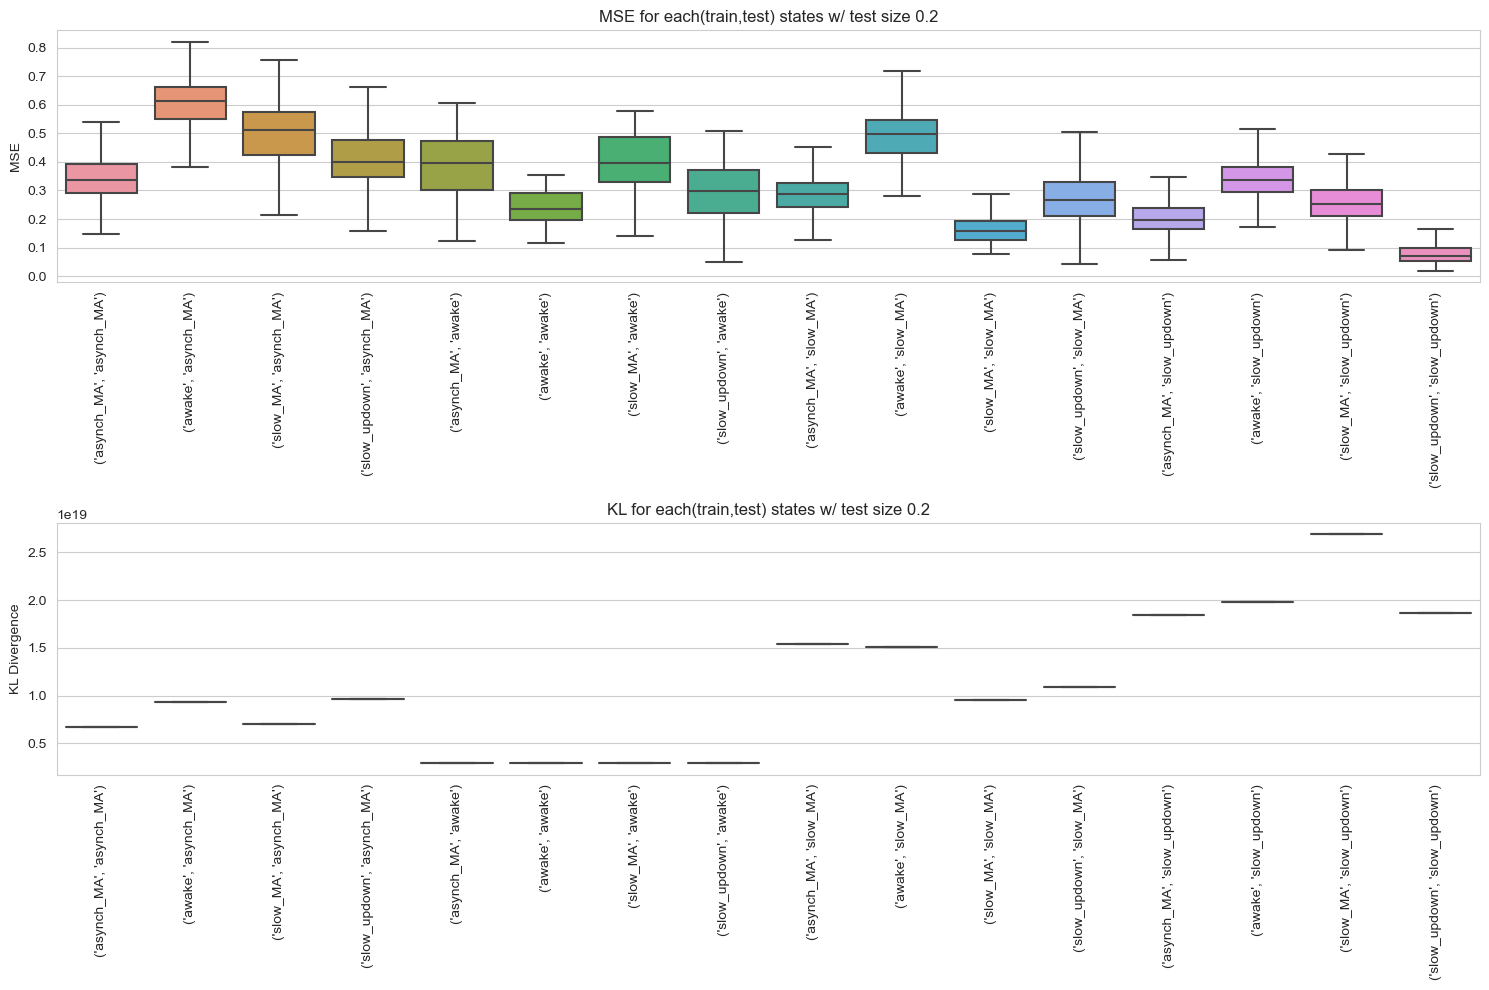

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Flatten keys and values to lists for easier plotting
keys = list(mse_values_dict.keys())
mse_values = list(mse_values_dict.values())
kl_values = list(kl_values_dict.values())
treshold= {}
for state in mse_values_dict.keys():
    if(state[0] == state[1]):
        mse_mean = np.mean(mse_values_dict[state])
        std = np.std(mse_values_dict[state])
        treshold[state] = mse_mean, std
        print(f"State {state}: mean {round(mse_mean,4)}, std {round(100*std/mse_mean,2)}%")

# Labels for the boxplots will be the string representation of the keys
labels = [str(key) for key in keys]

# Create boxplots
sns.boxplot(data=mse_values, ax=axs[0],showfliers=False)
sns.boxplot(data=kl_values, ax=axs[1],showfliers=False)
# Set labels and title
axs[0].set_xticklabels(labels, rotation = 90)
axs[0].set_title(f'MSE for each(train,test) states w/ test size {test_size}')
axs[0].set_ylabel('MSE')

axs[1].set_xticklabels(labels, rotation=90)
axs[1].set_title(f'KL for each(train,test) states w/ test size {test_size}')
axs[1].set_ylabel('KL Divergence')

plt.tight_layout()
plt.show()


## state unknown '4'

In [12]:
# Initialize a dictionary to store the MSE for each sample
mse_samples_state4 = {state_train: [] for state_train in autoencoders.keys()}

# Iterate over each sample in waveforms[4]
for i in range(waveforms_state_2d['unknown'].shape[0]):
    sample = waveforms_state_2d['unknown'][i].reshape(1, -1)  # Reshape the sample to have shape (1, n_features)
    # Use the autoencoders to predict this sample
    predicted_samples = {state_train: autoencoder.predict(sample) for state_train, autoencoder in autoencoders.items()}
    # Calculate and store the MSE for each autoencoder's prediction
    for state_train, predicted_sample in predicted_samples.items():
        mse_samples_state4[state_train].append(mean_squared_error(sample, predicted_sample))

# Convert the lists of MSEs to NumPy arrays for easier manipulation
for state_train in mse_samples_state4.keys():
    mse_samples_state4[state_train] = np.array(mse_samples_state4[state_train])

# Convert the MSE dictionary to a DataFrame for easier manipulation
mse_df = pd.DataFrame(mse_samples_state4)

print(mse_df.head())  # Print the first few rows of the DataFrame


1/1 [==============================] - 0s 7ms/step
   asynch_MA     awake   slow_MA  slow_updown
0   0.304597  0.516107  0.464188     0.289995
1   0.288545  0.316557  0.207053     0.099727
2   0.407901  0.482679  0.388780     0.246305
3   0.267407  0.295813  0.337278     0.133722
4   0.400359  0.501283  0.412453     0.347163


In [13]:
mse_df

,asynch_MA,awake,slow_MA,slow_updown
0,0.304597,0.516107,0.464188,0.289995
1,0.288545,0.316557,0.207053,0.099727
2,0.407901,0.482679,0.388780,0.246305
3,0.267407,0.295813,0.337278,0.133722
4,0.400359,0.501283,0.412453,0.347163
...,...,...,...,...
1317,0.564815,0.576526,0.581717,0.380711
1318,0.216210,0.409216,0.392776,0.224979
1319,0.401099,0.545360,0.467992,0.414844
1320,0.298071,0.405408,0.353823,0.201647


In [14]:
# for all columns substract the mean and divide by the std.
# the means are the tresholds previously calculated and stored at treshold[state][0] for the mean, and treshold[state][1] for the std
mse_df_processed = pd.DataFrame()
limits_for_state = {}
for state in treshold.keys():
    limits_for_state[state[0]] = (treshold[state][0] - 3*treshold[state][1])/treshold[state][0] # this is (mean - 2*std)/mean
    mse_df_processed[state[0]] = abs((mse_df[state[0]] - treshold[state][0])/treshold[state][1]) # we are zscoring really

Total number of rows that match: 544
Total number of rows that don't match: 315
Total number of rows that are unsure (MSE = 'artifact'): 158
Total number of rows that are half-states: 305

Combinations of MSE and GT for non-matching rows:
MSE = awake, GT = asynch_MA: 19 occurrences
MSE = slow_MA, GT = asynch_MA: 11 occurrences
MSE = asynch_MA, GT = awake: 32 occurrences
MSE = slow_MA, GT = awake: 7 occurrences
MSE = slow_MA, GT = slow_updown: 24 occurrences
MSE = asynch_MA, GT = slow_updown: 36 occurrences
MSE = awake, GT = slow_updown: 41 occurrences
MSE = slow_updown, GT = asynch_MA: 1 occurrences
MSE = asynch_MA, GT = slow_MA: 140 occurrences
MSE = awake, GT = slow_MA: 4 occurrences
Total number of rows that match: 1088
Total number of rows that don't match: 630
Total number of rows that are unsure (MSE = 'artifact'): 316
Total number of rows that are half-states: 610
Percentage of half-states involving both MA states together: 16.72%

Combinations of MSE and GT for non-matching row

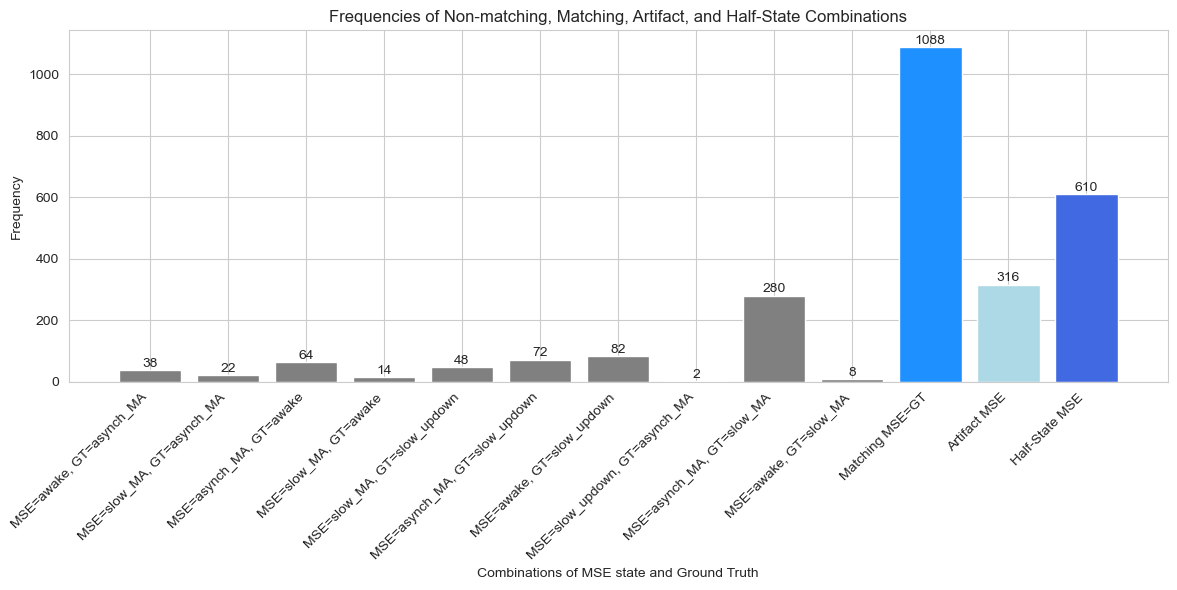

In [15]:
# Dictionary to store results
def calculate_and_print_results(mse_df_processed, gt):
    mse_df_processed
    min_mse_state_and_gt = {}
    # Iterating through each row of the dataframe
    for idx, row in mse_df_processed.iterrows():
        # Check states with MSE below 1
        states_below_threshold = row[row < 1.2].index.tolist()
        if len(states_below_threshold) == 1:
            state_with_min_mse = states_below_threshold[0]
        elif len(states_below_threshold) > 1:
            states_below_half = [state for state in states_below_threshold if row[state] < 0.6]
            if len(states_below_half) == 1:
                state_with_min_mse = states_below_half[0]
            else:
                state_with_min_mse = 'half-state'
        else:
            state_with_min_mse = 'artifact'

        # Create a tuple with the state_with_min_mse and the gt value for the current idx
        result_tuple = (state_with_min_mse, gt[idx])

        # Store the tuple in the dictionary using idx as the key
        min_mse_state_and_gt[idx] = result_tuple

    # Counters for matches, non-matches, unsure categories, and half-states
    matches_count = 0
    non_matches_count = 0
    unsure_count = 0
    half_states_count = 0

    # Dictionary to store the frequency of non-matching combinations
    non_matching_combinations_freq = {}

    # Lists to store indices where MSE is 'artifact' or 'half-state'
    unsure_indices = []
    half_states_indices = []

    # Iterate through the dictionary min_mse_state_and_gt
    for idx, (state, ground_truth) in min_mse_state_and_gt.items():
        if state == 'artifact':
            unsure_count += 1
            unsure_indices.append(idx)
        elif state == 'half-state':
            half_states_count += 1
            half_states_indices.append(idx)
        elif state == ground_truth:
            matches_count += 1
        else:
            non_matches_count += 1
            # Update the frequency of the non-matching combination
            non_matching_combinations_freq[(state, ground_truth)] = non_matching_combinations_freq.get((state, ground_truth), 0) + 1

    print(f"Total number of rows that match: {matches_count}")
    print(f"Total number of rows that don't match: {non_matches_count}")
    print(f"Total number of rows that are unsure (MSE = 'artifact'): {unsure_count}")
    print(f"Total number of rows that are half-states: {half_states_count}")

    print("\nCombinations of MSE and GT for non-matching rows:")
    for (mse_state, gt_state), freq in non_matching_combinations_freq.items():
        print(f"MSE = {mse_state}, GT = {gt_state}: {freq} occurrences")


    # Counter for half-states that have both MA states together
    ma_together_count = 0

    # Iterate through the dictionary min_mse_state_and_gt
    for idx, (state, ground_truth) in min_mse_state_and_gt.items():
        if state == 'artifact':
            unsure_count += 1
            unsure_indices.append(idx)
        elif state == 'half-state':
            half_states_count += 1
            half_states_indices.append(idx)

            # Check if both MA states are below threshold
            row = mse_df_processed.loc[idx]
            if row['asynch_MA'] < 1 and row['slow_MA'] < 1:
                ma_together_count += 1

        elif state == ground_truth:
            matches_count += 1
        else:
            non_matches_count += 1
            # Update the frequency of the non-matching combination
            non_matching_combinations_freq[(state, ground_truth)] = non_matching_combinations_freq.get((state, ground_truth), 0) + 1

    # Printing results
    print(f"Total number of rows that match: {matches_count}")
    print(f"Total number of rows that don't match: {non_matches_count}")
    print(f"Total number of rows that are unsure (MSE = 'artifact'): {unsure_count}")
    print(f"Total number of rows that are half-states: {half_states_count}")
    print(f"Percentage of half-states involving both MA states together: {(ma_together_count/half_states_count)*100:.2f}%")
    ma_percentage = (ma_together_count/half_states_count)*100

    print("\nCombinations of MSE and GT for non-matching rows:")
    for (mse_state, gt_state), freq in non_matching_combinations_freq.items():
        print(f"MSE = {mse_state}, GT = {gt_state}: {freq} occurrences")


    import matplotlib.pyplot as plt

    # Extracting combinations and frequencies
    combinations = list(map(lambda x: f"MSE={x[0]}, GT={x[1]}", non_matching_combinations_freq.keys()))
    frequencies = list(non_matching_combinations_freq.values())

    # Add the categories and their frequencies
    combinations.extend(["Matching MSE=GT", "Artifact MSE", "Half-State MSE"])
    frequencies.extend([matches_count, unsure_count, half_states_count])

    # Determine colors for each bar
    colors = []
    for combo in combinations:
        if combo == "Matching MSE=GT":
            colors.append('dodgerblue')
        elif combo == "Artifact MSE":
            colors.append('lightblue')
        elif combo == "Half-State MSE":
            colors.append('royalblue')
        else:
            colors.append('grey')

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(combinations, frequencies, color=colors)
    plt.ylabel('Frequency')
    plt.xlabel('Combinations of MSE state and Ground Truth')
    plt.title('Frequencies of Non-matching, Matching, Artifact, and Half-State Combinations')
    plt.xticks(rotation=45, ha="right")
    plt.yticks()

    # Annotate bars with the frequency count
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, str(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    return min_mse_state_and_gt, matches_count, non_matches_count, unsure_count, half_states_count, ma_percentage
min_mse_state_and_gt, matches_count, non_matches_count, unsure_count, half_states_count, ma_percentage = calculate_and_print_results(mse_df_processed, gt)

In [16]:
limits_for_state

{'asynch_MA': 0.2698849113670465,
 'awake': -0.17248975492556634,
 'slow_MA': -0.21916406649644216,
 'slow_updown': -0.4973228470799106}

In [24]:
min_mse_state_and_gt #key is the num_index, value is the (state_classified_w_AE, gt)

{0: ('asynch_MA', 'asynch_MA'),
 1: ('half-state', 'asynch_MA'),
 2: ('asynch_MA', 'asynch_MA'),
 3: ('awake', 'asynch_MA'),
 4: ('asynch_MA', 'asynch_MA'),
 5: ('half-state', 'asynch_MA'),
 6: ('half-state', 'asynch_MA'),
 7: ('slow_MA', 'asynch_MA'),
 8: ('asynch_MA', 'asynch_MA'),
 9: ('asynch_MA', 'asynch_MA'),
 10: ('half-state', 'asynch_MA'),
 11: ('half-state', 'asynch_MA'),
 12: ('half-state', 'asynch_MA'),
 13: ('asynch_MA', 'asynch_MA'),
 14: ('asynch_MA', 'asynch_MA'),
 15: ('asynch_MA', 'asynch_MA'),
 16: ('half-state', 'asynch_MA'),
 17: ('asynch_MA', 'asynch_MA'),
 18: ('asynch_MA', 'asynch_MA'),
 19: ('asynch_MA', 'asynch_MA'),
 20: ('asynch_MA', 'asynch_MA'),
 21: ('awake', 'asynch_MA'),
 22: ('asynch_MA', 'asynch_MA'),
 23: ('half-state', 'asynch_MA'),
 24: ('half-state', 'asynch_MA'),
 25: ('asynch_MA', 'asynch_MA'),
 26: ('asynch_MA', 'asynch_MA'),
 27: ('asynch_MA', 'asynch_MA'),
 28: ('artifact', 'asynch_MA'),
 29: ('asynch_MA', 'asynch_MA'),
 30: ('half-state', 'a

In [28]:
good_classification = [893] #this is slow_MA good classification
good_classification = [37, 38, 39 ] # this is asynch_MA good classification
good_classification = [148] # this is slow_updown
good_classification = [87] # this is awake -- generally awake are very wrong classified in this session in the first 1000 values (first sec)

## reconstruction of each type of unknown

In [46]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def plot_reconstructions(sample_idx, waveforms_state_2d,autoencoders):
    # Select the sample
    sample = waveforms_state_2d['unknown'][sample_idx].reshape(1, -1)

    # Use the autoencoders to predict this sample
    predicted_samples = {state_train: autoencoder.predict(sample) for state_train, autoencoder in autoencoders.items()}

    # Create a figure for the plots
    fig, axs = plt.subplots(5, 2, figsize=(8,8), constrained_layout=True)

    # Plot the original sample
    axs[0,0].plot(sample[0], color='black')
    axs[0,0].set_title('Original')

    # Get the y-axis limits of the original signal
    ylim = axs[0,0].get_ylim()

    # Plot the reconstructed samples
    state_names = ['asynch_MA', 'awake', 'slow_MA', 'slow_updown']
    colors = ['blue', 'green', 'purple', 'orange']

    for i, (state_train, predicted_sample) in enumerate(predicted_samples.items()):
        axs[i+1,0].plot(sample[0], color='black')  # Original sample
        axs[i+1,0].plot(predicted_sample[0], color=colors[i])  # Reconstructed sample
        axs[i+1,0].set_ylim(ylim)  # Set the y-axis limits to match the original signal
        axs[i+1,0].set_title(f'Original and reconstructed by {state_names[i]} AE')

    # Plot zoomed view
    zoom_samples = 500
    axs[0,1].plot(sample[0][:zoom_samples], color='black')
    axs[0,1].set_title('Original - Zoomed')

    # Get the y-axis limits of the zoomed in original signal
    ylim_zoomed = axs[0,1].get_ylim()

    for i, (state_train, predicted_sample) in enumerate(predicted_samples.items()):
        axs[i+1,1].plot(sample[0][:zoom_samples], color='black')  # Original sample zoomed
        axs[i+1,1].plot(predicted_sample[0][:zoom_samples], color=colors[i])  # Reconstructed sample zoomed
        axs[i+1,1].set_ylim(ylim_zoomed)  # Set the y-axis limits to match the zoomed in original signal
        axs[i+1,1].set_title(f'Original and reconstructed by {state_names[i]} AE - Zoomed')

    plt.show()
def plot_timeseries(original_indices,concatenated_data,concatenated_states):
    fig, axs = plt.subplots(len(original_indices), 1, figsize=(15, 6 * len(original_indices)))

    # Define color map for each state
    color_map = {0: 'blue', 1: 'green', 2: 'purple', 3: 'orange', 4: 'red'}

    for idx, original_index in enumerate(original_indices):
        # Initialize the lists to store the concatenated waveform and colors
        concatenated_waveform = []
        concatenated_colors = []

        # Get the indices for the 10 samples before and after the current index
        indices_before = list(range(original_index - 10, original_index))
        indices_after = list(range(original_index + 1, original_index + 11))
        indices = indices_before + [original_index] + indices_after

        # Concatenate the waveforms
        for i in indices:
            concatenated_waveform.extend(concatenated_data[0, :, i])
            # Assign a color to each sample based on its state
            state = concatenated_states[i]
            concatenated_colors.extend([color_map[state] for _ in range(concatenated_data.shape[1])])

        # Plot the concatenated waveform on the current subplot
        axs[idx].plot(concatenated_waveform, color='gray')

        # Add color to the samples based on their states
        for i, color in enumerate(concatenated_colors):
            axs[idx].plot(i, concatenated_waveform[i], color=color, marker='o', markersize=2)

        axs[idx].set_title(f'Concatenated Waveforms for Original Index {original_index}')
        axs[idx].set_xlabel('Concatenated Time')
        axs[idx].set_ylabel('Amplitude')

    # Create custom legends for each state
    patches = [mpatches.Patch(color=color, label=f'State {state}') for state, color in color_map.items()]
    plt.legend(handles=patches, loc='upper right')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 7ms/step


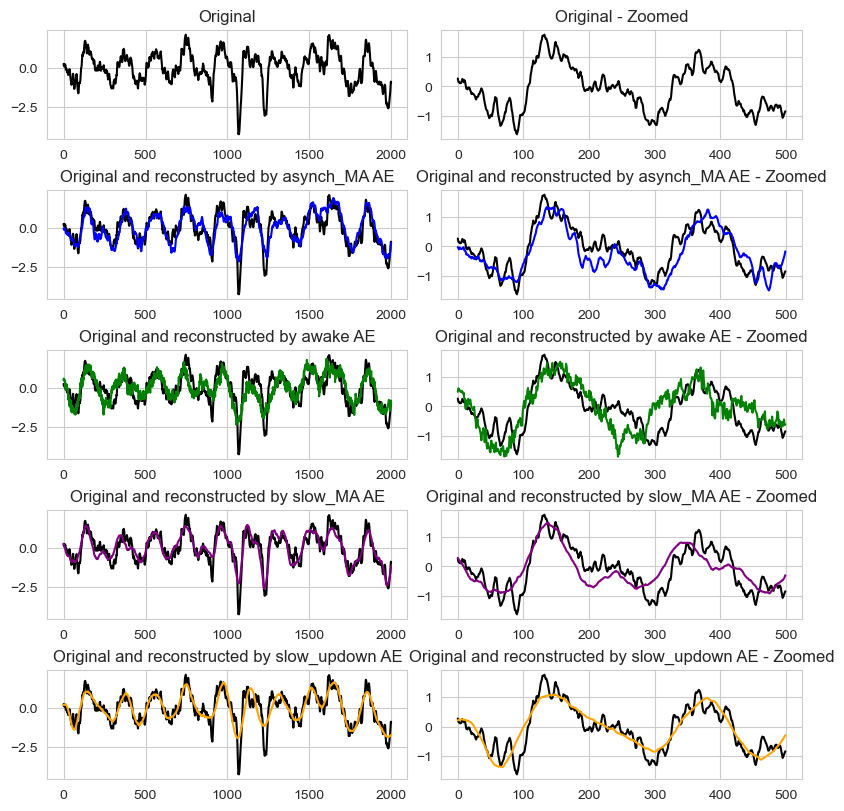

In [47]:
# for good classifications:
sample_idx = 893 # match with slow_ma
plot_reconstructions(sample_idx, waveforms_state_2d,autoencoders)

1/1 [==============================] - 0s 7ms/step


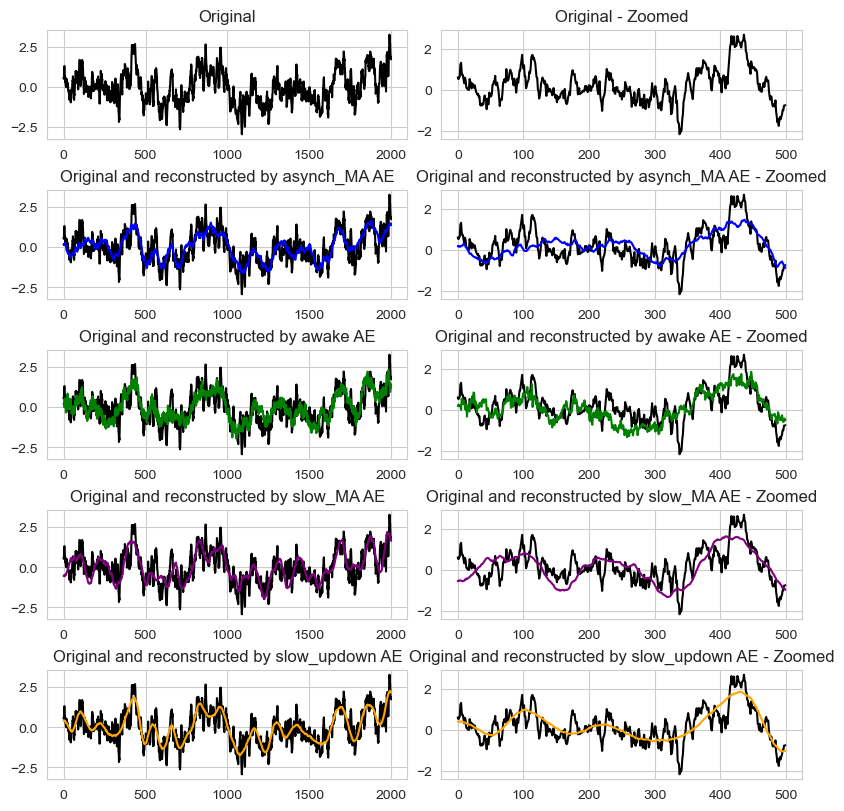

In [48]:
# for good classifications:
sample_idx = 38 # match with asynch_ma
plot_reconstructions(sample_idx, waveforms_state_2d,autoencoders)

1/1 [==============================] - 0s 8ms/step


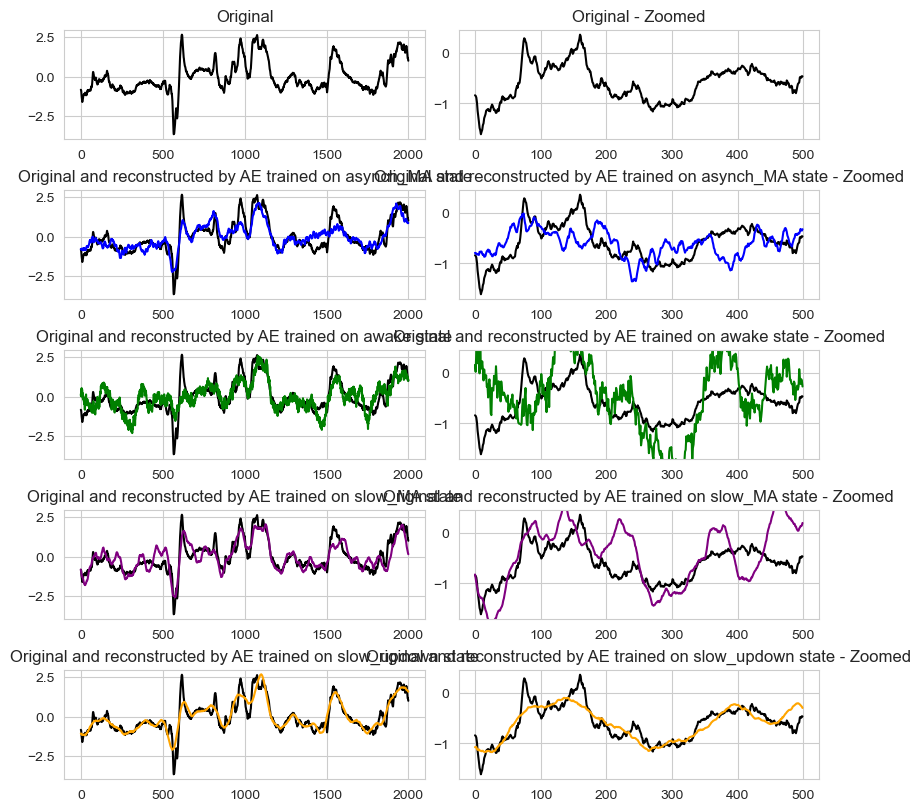

In [43]:
# for good classifications:
sample_idx = 138 # match with slow_updown
plot_reconstructions(sample_idx, waveforms_state_2d,autoencoders)

1/1 [==============================] - 0s 7ms/step


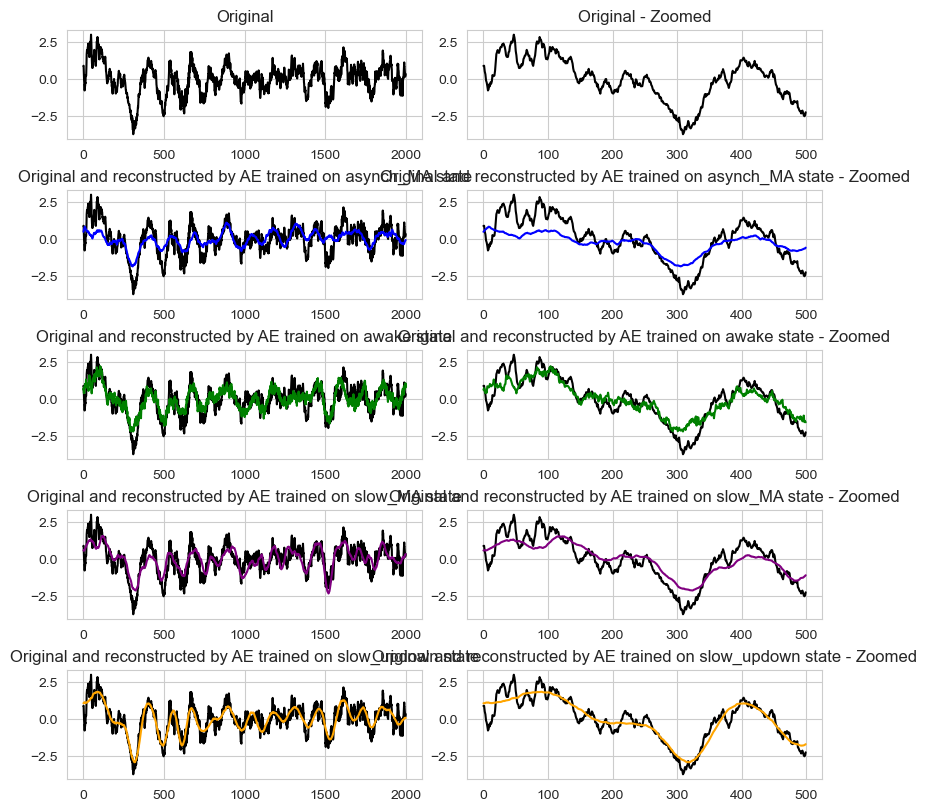

In [44]:
# for good classifications:
sample_idx = 87 # match with awake
plot_reconstructions(sample_idx, waveforms_state_2d,autoencoders)

### this is an artifact technically

1/1 [==============================] - 0s 8ms/step


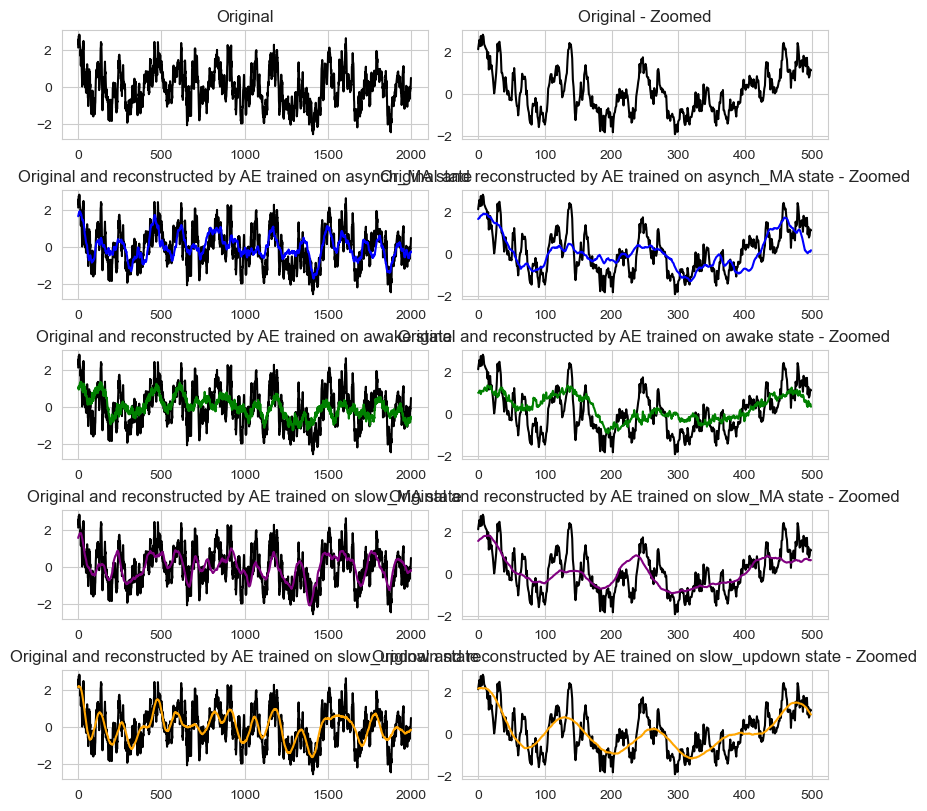

In [45]:
sample_idx = 582
list_of_artifacts = [419,571, 576, 582] #you can try others, but these are quite clear to me
plot_reconstructions(sample_idx, waveforms_state_2d,autoencoders)

## this is a half-state

In [49]:
half_state_MAs = [840,859, 872, 879, 880, ] #MA states, and the GT is MA_state

## this is missclassification

In [50]:
miss_classification_MA = [844,846,862,867,
                          882, 889, 892,] #missclassification involving the two MA states (for example, slow_MA is missclassified as asynch_MA)
miss_class = [142, 149, 150, ]#awake but in GT is slow_updown
